<a href="https://colab.research.google.com/github/ISE-CS4445-AI/challenge-6-Naem-Haq/blob/main/challenge-6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge #6: Reducing Overfitting with Regularization (FashionMNIST)

**Instructions**:
- This challenge builds on **Week 6**’s regularization lessons: **data augmentation**, **dropout**, and **weight decay**.
- We demonstrate a baseline CNN on **FashionMNIST** that clearly overfits. Then we apply these techniques to see the improvement.

**Scoring**:  9 points total. Fill in the `# TODO` placeholders and fill in the final reflection markdown cell. **There is no autograder** for this assignment. If your code works without errors and achieves the objectives of reducing overfitting by the end of this challenge, you will have done well. 👍

We’ll use the **FashionMNIST** dataset, which consists of 60,000 training images and 10,000 test images of 28x28 grayscale images of 10 different fashion categories. By applying these techniques, we aim to reduce overfitting and improve robust performance.

---

## Imports & Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

print("Torch version:", torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Torch version: 2.5.1+cu124
Using device: cuda


### Utility functions

Defining the utility function to plot metrics below.

In [2]:
'''
Description:
Utility function to plot line plots in a single graph

Params:
dataDict: List - A list of tuples containing the data to be plotted and corresponding plot params as a dictionary (optional).
           Expected key names in paramDict:
           -> label: str - String label to be given to the plot.
                           Only necessary if the 'legend' function param is set to True (False by default).
           -> ha: str - Specifies the horizontal alignment ('left', 'right' or 'center') of text above each point in the plot.
           -> fontsize: int - Sets the font size of text displayed above each point in the plot.
           -> marker: str - Sets the style of marker to be displayed for each data point on the plot. Set to 'o' by default.
           -> decimalPlaces: int - Sets the number of decimal places to display for each data point.
           -> displayPercent: bool - Boolean to decide whether to display numbers in percentage format.
           -> displayOffset: float - positive or negative float value that determines the display offset of text above data point.
title: str - [optional] Title to be set for the graph.
xlabel: str - [optional] Label for the x-axis to be set for the graph.
ylabel: str - [optional] Label for the y-axis to be set for the graph.
figSize: Tuple - [optional] Sets a custom figure size for the plot based on the width and height values passed as a tuple pair.
legend: bool - [optional] Boolean to decide whether to show the legend or not. Set to False by default
'''
def plotMetrics(dataList, X, title='', xlabel='', ylabel='', figSize=None, legend=False):
    if figSize:
            plt.figure(figsize=(figSize))
    for data in dataList:
        y, paramDict = data
        # Getting plot params
        label = paramDict['label'] if 'label' in paramDict else ''
        marker = paramDict['marker'] if 'marker' in paramDict else 'o'
        ha = paramDict['ha'] if 'ha' in paramDict else 'center'
        fontSize = paramDict['fontSize'] if 'fontSize' in paramDict else 8
        decimalPlaces = paramDict['decimalPlaces'] if 'decimalPlaces' in paramDict else 2
        displayPercent = paramDict['displayPercent'] if 'displayPercent' in paramDict else False
        displayOffset = paramDict['displayOffset'] if 'displayOffset' in paramDict else 0.005

        plt.plot(X, y, label=label, marker=marker)

        # Getting the data values to show on the plotted points along the line
        for i, v in enumerate(y):
            percentMultiplier = 100 if displayPercent else 1
            v_str = f'{v * percentMultiplier:.{decimalPlaces}f}{"%" if displayPercent else ""}'
            plt.text(i + 1, v + displayOffset, v_str, ha=ha, fontsize=fontSize)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if legend:
        plt.legend()
    plt.show()

## Task 1: getTransforms(augmentation=False) <font color='green'>(1 point)</font>

**Goal**: Return a **train_transform** and a **test_transform**.  
- If `augmentation=True`, apply random transformations. Otherwise just basic.  
- *FashionMNIST* is 28×28 grayscale, so consider **random horizontal flip** or **random rotation**. Keep it simple.

In [3]:
def getTransforms(augmentation=False):
    # mean,std for FashionMNIST (approx)
    mean = (0.2860,)
    std = (0.3530,)

    # TODO: define the transformation for the test set (without any data augmentation)
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    if augmentation:
        # TODO: define the transformation for the train set (with data augmentation)
        train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        return train_transform, test_transform

    return test_transform, test_transform


## Task 2: create the dataloaders <font color='green'>(1 point)</font>

In [4]:
def load_fashionMNIST_data(batch_size=64, augmentation=False):
    """
    return train_loader, test_loader
    """

    train_transform, test_transform = getTransforms(augmentation)

    # TODO: download the FashionMNIST dataset
    train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transform)
    test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transform)

    # TODO: create the data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

train_loader, test_loader = load_fashionMNIST_data(batch_size=64)
print("Train set size:", len(train_loader.dataset))
print("Test set size:", len(test_loader.dataset))


100%|██████████| 26.4M/26.4M [00:02<00:00, 10.9MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 208kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.94MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 12.7MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Train set size: 60000
Test set size: 10000


## Task 3: Define a CNN with Dropout  <font color='green'>(2 points)</font>

**Task**:  
- Build a small **CNN** with a few convolution layers, each followed by ReLU & maxpool.  
- Insert **dropout** layers (e.g., `nn.Dropout(0.3)`) to help reduce overfitting.  
- The final linear outputs 10 classes.  
- We'll call it `NetFashion`.

In [5]:
class NetFashion(nn.Module):
    def __init__(self, dropout_prob=0.3, useRegularization=False):
        super().__init__()
        self.useRegularization = useRegularization

        # TODO: Build a sample CNN architecture
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2,2)

        if self.useRegularization:
            self.dropout = nn.Dropout(dropout_prob)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(256 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        if self.useRegularization:
            x = self.dropout(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))

        if self.useRegularization:
            x = self.dropout(x)

        out = self.fc2(x)
        return out


## Training Loop

Below is a standard training loop with helper train and test methods defined which should look familiar by now. :)

In [6]:
def train(dataloader, model, loss_fn, optimiser):
    size = len(dataloader.dataset)
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        optimiser.zero_grad()

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # This is the backprop set up. Explain what each of the steps do
        loss.backward()
        optimiser.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss += loss_fn(pred, y).item()
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    loss /= num_batches
    accuracy /= size

    return loss, accuracy

def train_loop(train_dataloader, test_dataloader, model, loss_fn, optimiser, epochs):
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []

    # Iterate over each epoch
    for t in tqdm(range(epochs), desc="Epochs"):
        print(f"Epoch {t+1}:\n")
        train(train_dataloader, model, loss_fn, optimiser)

        # Get the overall loss and accuracy for both train and test datasets
        tr_loss, tr_acc = test(train_dataloader, model, loss_fn)
        ts_loss, ts_acc = test(test_dataloader, model, loss_fn)

        print(f"Train Error: \n Accuracy: {(100*tr_acc):>0.1f}%, Avg loss: {tr_loss:>8f} \n")
        print(f"Test Error: \n Accuracy: {(100*ts_acc):>0.1f}%, Avg loss: {ts_loss:>8f} \n")

        # Store and return the losses and accuracies. We can graph these later
        train_loss = train_loss + [tr_loss]
        train_accuracy = train_accuracy + [tr_acc]
        test_loss = test_loss + [ts_loss]
        test_accuracy = test_accuracy + [ts_acc]

    print("Done training!")
    return train_loss, train_accuracy, test_loss, test_accuracy

## Task 4: Evaluate & Check Test Accuracy

**Task**:  
1. Measure train and test metrics for non-regularised model with non-augmented data.  
2. Do the same train and test loop for your regularised model on augmented data with weight decay in the optimiser and observe the difference.
   1. However, apply all the different techniques individually.
   2. Run the code cells to plot metrics after each experiment

### Task 4.1: Non-regularised model with non-augmented data  <font color='green'>(1 point)</font>

In [7]:
model = NetFashion().to(device) # Getting the Fashion MNIST model

# TODO: Define the loss function and the optimiser
loss_fn = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr=0.001)


In [8]:
epochs = 10
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:

loss: 2.300749  [   64/60000]
loss: 0.598566  [ 6464/60000]
loss: 0.588953  [12864/60000]
loss: 0.357464  [19264/60000]
loss: 0.242656  [25664/60000]
loss: 0.235941  [32064/60000]
loss: 0.274082  [38464/60000]
loss: 0.440505  [44864/60000]
loss: 0.312782  [51264/60000]
loss: 0.210899  [57664/60000]


Epochs:  10%|█         | 1/10 [00:34<05:14, 34.92s/it]

Train Error: 
 Accuracy: 90.2%, Avg loss: 0.270064 

Test Error: 
 Accuracy: 88.8%, Avg loss: 0.315328 

Epoch 2:

loss: 0.262847  [   64/60000]
loss: 0.265265  [ 6464/60000]
loss: 0.378708  [12864/60000]
loss: 0.245849  [19264/60000]
loss: 0.262908  [25664/60000]
loss: 0.205163  [32064/60000]
loss: 0.212328  [38464/60000]
loss: 0.357460  [44864/60000]
loss: 0.401090  [51264/60000]
loss: 0.335134  [57664/60000]


Epochs:  20%|██        | 2/10 [01:09<04:39, 34.93s/it]

Train Error: 
 Accuracy: 93.7%, Avg loss: 0.173710 

Test Error: 
 Accuracy: 91.4%, Avg loss: 0.233260 

Epoch 3:

loss: 0.167743  [   64/60000]
loss: 0.204285  [ 6464/60000]
loss: 0.097839  [12864/60000]
loss: 0.023153  [19264/60000]
loss: 0.079982  [25664/60000]
loss: 0.150213  [32064/60000]
loss: 0.167341  [38464/60000]
loss: 0.100849  [44864/60000]
loss: 0.108798  [51264/60000]
loss: 0.174589  [57664/60000]


Epochs:  30%|███       | 3/10 [01:44<04:03, 34.76s/it]

Train Error: 
 Accuracy: 95.2%, Avg loss: 0.130016 

Test Error: 
 Accuracy: 91.8%, Avg loss: 0.221137 

Epoch 4:

loss: 0.101908  [   64/60000]
loss: 0.032198  [ 6464/60000]
loss: 0.083418  [12864/60000]
loss: 0.165435  [19264/60000]
loss: 0.086737  [25664/60000]
loss: 0.032108  [32064/60000]
loss: 0.033120  [38464/60000]
loss: 0.073488  [44864/60000]
loss: 0.112298  [51264/60000]
loss: 0.183794  [57664/60000]


Epochs:  40%|████      | 4/10 [02:18<03:26, 34.38s/it]

Train Error: 
 Accuracy: 96.8%, Avg loss: 0.089621 

Test Error: 
 Accuracy: 92.8%, Avg loss: 0.218705 

Epoch 5:

loss: 0.104131  [   64/60000]
loss: 0.044704  [ 6464/60000]
loss: 0.135270  [12864/60000]
loss: 0.087125  [19264/60000]
loss: 0.085004  [25664/60000]
loss: 0.065483  [32064/60000]
loss: 0.039321  [38464/60000]
loss: 0.138260  [44864/60000]
loss: 0.110374  [51264/60000]
loss: 0.079343  [57664/60000]


Epochs:  50%|█████     | 5/10 [02:51<02:50, 34.14s/it]

Train Error: 
 Accuracy: 97.3%, Avg loss: 0.070830 

Test Error: 
 Accuracy: 92.7%, Avg loss: 0.261089 

Epoch 6:

loss: 0.063794  [   64/60000]
loss: 0.078659  [ 6464/60000]
loss: 0.039529  [12864/60000]
loss: 0.088770  [19264/60000]
loss: 0.126421  [25664/60000]
loss: 0.043030  [32064/60000]
loss: 0.069627  [38464/60000]
loss: 0.088927  [44864/60000]
loss: 0.056570  [51264/60000]
loss: 0.120863  [57664/60000]


Epochs:  60%|██████    | 6/10 [03:25<02:16, 34.07s/it]

Train Error: 
 Accuracy: 98.3%, Avg loss: 0.046538 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.262796 

Epoch 7:

loss: 0.024034  [   64/60000]
loss: 0.016279  [ 6464/60000]
loss: 0.055926  [12864/60000]
loss: 0.056046  [19264/60000]
loss: 0.051682  [25664/60000]
loss: 0.038134  [32064/60000]
loss: 0.031189  [38464/60000]
loss: 0.043224  [44864/60000]
loss: 0.027682  [51264/60000]
loss: 0.023773  [57664/60000]


Epochs:  70%|███████   | 7/10 [03:59<01:41, 33.97s/it]

Train Error: 
 Accuracy: 98.9%, Avg loss: 0.033315 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.296362 

Epoch 8:

loss: 0.061183  [   64/60000]
loss: 0.040944  [ 6464/60000]
loss: 0.077959  [12864/60000]
loss: 0.037944  [19264/60000]
loss: 0.010649  [25664/60000]
loss: 0.008613  [32064/60000]
loss: 0.015593  [38464/60000]
loss: 0.012182  [44864/60000]
loss: 0.042679  [51264/60000]
loss: 0.136312  [57664/60000]


Epochs:  80%|████████  | 8/10 [04:33<01:07, 33.80s/it]

Train Error: 
 Accuracy: 98.9%, Avg loss: 0.029864 

Test Error: 
 Accuracy: 92.6%, Avg loss: 0.345376 

Epoch 9:

loss: 0.027129  [   64/60000]
loss: 0.002480  [ 6464/60000]
loss: 0.004748  [12864/60000]
loss: 0.036522  [19264/60000]
loss: 0.024810  [25664/60000]
loss: 0.087586  [32064/60000]
loss: 0.007860  [38464/60000]
loss: 0.098462  [44864/60000]
loss: 0.028969  [51264/60000]
loss: 0.037146  [57664/60000]


Epochs:  90%|█████████ | 9/10 [05:06<00:33, 33.66s/it]

Train Error: 
 Accuracy: 99.0%, Avg loss: 0.028763 

Test Error: 
 Accuracy: 92.3%, Avg loss: 0.407627 

Epoch 10:

loss: 0.033317  [   64/60000]
loss: 0.098799  [ 6464/60000]
loss: 0.043049  [12864/60000]
loss: 0.017208  [19264/60000]
loss: 0.019457  [25664/60000]
loss: 0.024989  [32064/60000]
loss: 0.075437  [38464/60000]
loss: 0.041073  [44864/60000]
loss: 0.050015  [51264/60000]
loss: 0.027695  [57664/60000]


Epochs: 100%|██████████| 10/10 [05:39<00:00, 33.98s/it]

Train Error: 
 Accuracy: 99.2%, Avg loss: 0.024239 

Test Error: 
 Accuracy: 92.7%, Avg loss: 0.357970 

Done training!


Plotting metrics

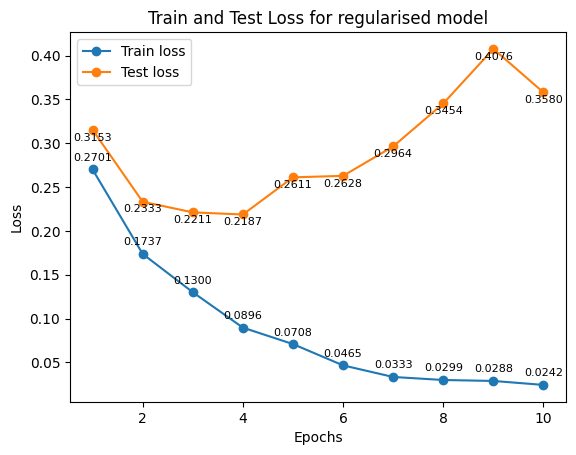

In [9]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.01}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.012})]
plotTitle = 'Train and Test Loss for regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True)


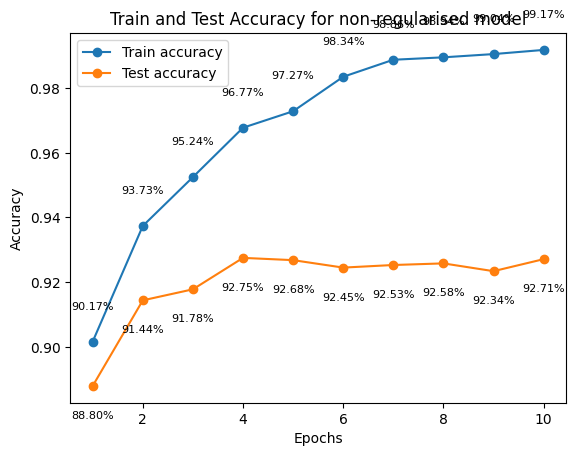

In [10]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': 0.01,
                                      'decimalPlaces': 2, 'displayPercent': True}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': -0.01,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for non-regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True)


### Task 4.2: With regularisation and data augmentation applied <font color='green'>(3 points)</font>
Train and test the same model with different regularisation techniques applied where you apply them one at a time

In [12]:
# Apply only data augmentation
train_loader, test_loader = load_fashionMNIST_data(batch_size=64, augmentation=True)

# Initialize model
model = NetFashion().to(device)

epochs = 10  # Increasing the number of epochs by 5 since the learning will be more gradual.

# Define optimizer
optimiser = optim.Adam(model.parameters(), lr=0.001)

# Train model
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:

loss: 2.301798  [   64/60000]
loss: 0.595592  [ 6464/60000]
loss: 0.589955  [12864/60000]
loss: 0.573469  [19264/60000]
loss: 0.514737  [25664/60000]
loss: 0.253822  [32064/60000]
loss: 0.337837  [38464/60000]
loss: 0.359593  [44864/60000]
loss: 0.372316  [51264/60000]
loss: 0.280696  [57664/60000]


Epochs:  10%|█         | 1/10 [00:49<07:27, 49.76s/it]

Train Error: 
 Accuracy: 88.4%, Avg loss: 0.308419 

Test Error: 
 Accuracy: 88.1%, Avg loss: 0.316499 

Epoch 2:

loss: 0.482921  [   64/60000]
loss: 0.180080  [ 6464/60000]
loss: 0.339481  [12864/60000]
loss: 0.160436  [19264/60000]
loss: 0.291131  [25664/60000]
loss: 0.318210  [32064/60000]
loss: 0.439911  [38464/60000]
loss: 0.212645  [44864/60000]
loss: 0.222506  [51264/60000]
loss: 0.208677  [57664/60000]


Epochs:  20%|██        | 2/10 [01:39<06:39, 49.96s/it]

Train Error: 
 Accuracy: 91.4%, Avg loss: 0.230928 

Test Error: 
 Accuracy: 90.6%, Avg loss: 0.251802 

Epoch 3:

loss: 0.205337  [   64/60000]
loss: 0.202739  [ 6464/60000]
loss: 0.174574  [12864/60000]
loss: 0.238029  [19264/60000]
loss: 0.332202  [25664/60000]
loss: 0.193694  [32064/60000]
loss: 0.288006  [38464/60000]
loss: 0.169356  [44864/60000]
loss: 0.169478  [51264/60000]
loss: 0.264719  [57664/60000]


Epochs:  30%|███       | 3/10 [02:31<05:54, 50.66s/it]

Train Error: 
 Accuracy: 92.7%, Avg loss: 0.197245 

Test Error: 
 Accuracy: 91.7%, Avg loss: 0.232075 

Epoch 4:

loss: 0.259294  [   64/60000]
loss: 0.224402  [ 6464/60000]
loss: 0.095596  [12864/60000]
loss: 0.166698  [19264/60000]
loss: 0.147304  [25664/60000]
loss: 0.191746  [32064/60000]
loss: 0.176017  [38464/60000]
loss: 0.167606  [44864/60000]
loss: 0.177544  [51264/60000]
loss: 0.213402  [57664/60000]


Epochs:  40%|████      | 4/10 [03:20<04:59, 49.88s/it]

Train Error: 
 Accuracy: 93.2%, Avg loss: 0.188770 

Test Error: 
 Accuracy: 91.9%, Avg loss: 0.221878 

Epoch 5:

loss: 0.306130  [   64/60000]
loss: 0.105320  [ 6464/60000]
loss: 0.152938  [12864/60000]
loss: 0.213747  [19264/60000]
loss: 0.160092  [25664/60000]
loss: 0.167058  [32064/60000]
loss: 0.271139  [38464/60000]
loss: 0.074172  [44864/60000]
loss: 0.297513  [51264/60000]
loss: 0.046791  [57664/60000]


Epochs:  50%|█████     | 5/10 [04:08<04:07, 49.47s/it]

Train Error: 
 Accuracy: 93.7%, Avg loss: 0.172887 

Test Error: 
 Accuracy: 92.0%, Avg loss: 0.222565 

Epoch 6:

loss: 0.154818  [   64/60000]
loss: 0.084084  [ 6464/60000]
loss: 0.096637  [12864/60000]
loss: 0.175055  [19264/60000]
loss: 0.191071  [25664/60000]
loss: 0.099850  [32064/60000]
loss: 0.104586  [38464/60000]
loss: 0.151061  [44864/60000]
loss: 0.142385  [51264/60000]
loss: 0.064898  [57664/60000]


Epochs:  60%|██████    | 6/10 [04:57<03:16, 49.20s/it]

Train Error: 
 Accuracy: 94.6%, Avg loss: 0.149324 

Test Error: 
 Accuracy: 92.8%, Avg loss: 0.214165 

Epoch 7:

loss: 0.249156  [   64/60000]
loss: 0.300992  [ 6464/60000]
loss: 0.111067  [12864/60000]
loss: 0.099425  [19264/60000]
loss: 0.157843  [25664/60000]
loss: 0.170188  [32064/60000]
loss: 0.078116  [38464/60000]
loss: 0.190304  [44864/60000]
loss: 0.228865  [51264/60000]
loss: 0.290681  [57664/60000]


Epochs:  70%|███████   | 7/10 [05:45<02:26, 48.79s/it]

Train Error: 
 Accuracy: 94.4%, Avg loss: 0.152283 

Test Error: 
 Accuracy: 92.8%, Avg loss: 0.215298 

Epoch 8:

loss: 0.146315  [   64/60000]
loss: 0.104512  [ 6464/60000]
loss: 0.116177  [12864/60000]
loss: 0.121635  [19264/60000]
loss: 0.208882  [25664/60000]
loss: 0.160926  [32064/60000]
loss: 0.196410  [38464/60000]
loss: 0.122053  [44864/60000]
loss: 0.127229  [51264/60000]
loss: 0.254982  [57664/60000]


Epochs:  80%|████████  | 8/10 [06:32<01:36, 48.22s/it]

Train Error: 
 Accuracy: 95.0%, Avg loss: 0.133306 

Test Error: 
 Accuracy: 92.9%, Avg loss: 0.216222 

Epoch 9:

loss: 0.140284  [   64/60000]
loss: 0.105676  [ 6464/60000]
loss: 0.107005  [12864/60000]
loss: 0.071949  [19264/60000]
loss: 0.086894  [25664/60000]
loss: 0.101667  [32064/60000]
loss: 0.105395  [38464/60000]
loss: 0.212125  [44864/60000]
loss: 0.195738  [51264/60000]
loss: 0.172587  [57664/60000]


Epochs:  90%|█████████ | 9/10 [07:19<00:47, 47.93s/it]

Train Error: 
 Accuracy: 95.5%, Avg loss: 0.122115 

Test Error: 
 Accuracy: 93.0%, Avg loss: 0.220095 

Epoch 10:

loss: 0.247533  [   64/60000]
loss: 0.110339  [ 6464/60000]
loss: 0.107573  [12864/60000]
loss: 0.045811  [19264/60000]
loss: 0.132031  [25664/60000]
loss: 0.304819  [32064/60000]
loss: 0.181086  [38464/60000]
loss: 0.100176  [44864/60000]
loss: 0.124654  [51264/60000]
loss: 0.135736  [57664/60000]


Epochs: 100%|██████████| 10/10 [08:07<00:00, 48.70s/it]

Train Error: 
 Accuracy: 95.9%, Avg loss: 0.107807 

Test Error: 
 Accuracy: 93.0%, Avg loss: 0.215240 

Done training!


Plotting metrics

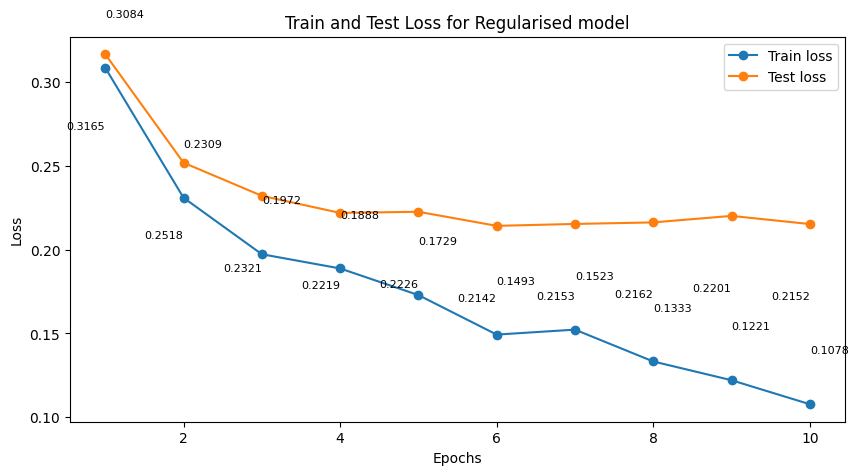

In [13]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling custom utility function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))


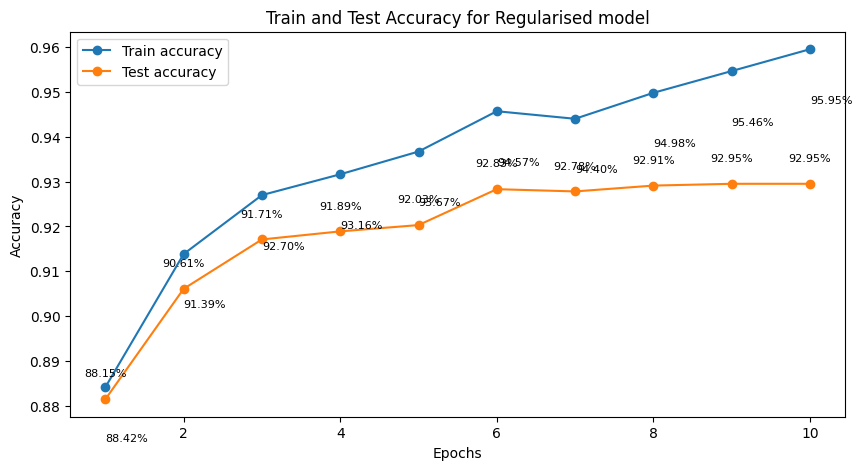

In [14]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling custom utility function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))


In [15]:
# Apply only regularisation on the CNN model
train_loader, test_loader = load_fashionMNIST_data(batch_size=64, augmentation=False)

# Initialize model with regularization
model = NetFashion(useRegularization=True).to(device)

epochs = 10  # Increasing the number of epochs by 5 since the learning will be more gradual.

# Define optimizer
optimiser = optim.Adam(model.parameters(), lr=0.001)

# Train model
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:

loss: 2.305875  [   64/60000]
loss: 0.641733  [ 6464/60000]
loss: 0.549331  [12864/60000]
loss: 0.485458  [19264/60000]
loss: 0.419743  [25664/60000]
loss: 0.524785  [32064/60000]
loss: 0.364958  [38464/60000]
loss: 0.299304  [44864/60000]
loss: 0.407538  [51264/60000]
loss: 0.129323  [57664/60000]


Epochs:  10%|█         | 1/10 [00:32<04:54, 32.77s/it]

Train Error: 
 Accuracy: 91.0%, Avg loss: 0.243581 

Test Error: 
 Accuracy: 89.8%, Avg loss: 0.279343 

Epoch 2:

loss: 0.139765  [   64/60000]
loss: 0.243918  [ 6464/60000]
loss: 0.214491  [12864/60000]
loss: 0.281827  [19264/60000]
loss: 0.243320  [25664/60000]
loss: 0.234051  [32064/60000]
loss: 0.121513  [38464/60000]
loss: 0.356817  [44864/60000]
loss: 0.242094  [51264/60000]
loss: 0.184014  [57664/60000]


Epochs:  20%|██        | 2/10 [01:05<04:20, 32.56s/it]

Train Error: 
 Accuracy: 93.2%, Avg loss: 0.182124 

Test Error: 
 Accuracy: 91.3%, Avg loss: 0.231770 

Epoch 3:

loss: 0.284449  [   64/60000]
loss: 0.176787  [ 6464/60000]
loss: 0.100407  [12864/60000]
loss: 0.258829  [19264/60000]
loss: 0.200022  [25664/60000]
loss: 0.109882  [32064/60000]
loss: 0.120698  [38464/60000]
loss: 0.188323  [44864/60000]
loss: 0.125424  [51264/60000]
loss: 0.149492  [57664/60000]


Epochs:  30%|███       | 3/10 [01:37<03:46, 32.41s/it]

Train Error: 
 Accuracy: 95.0%, Avg loss: 0.137730 

Test Error: 
 Accuracy: 92.3%, Avg loss: 0.205251 

Epoch 4:

loss: 0.126081  [   64/60000]
loss: 0.275751  [ 6464/60000]
loss: 0.136302  [12864/60000]
loss: 0.181319  [19264/60000]
loss: 0.114203  [25664/60000]
loss: 0.211595  [32064/60000]
loss: 0.202715  [38464/60000]
loss: 0.077924  [44864/60000]
loss: 0.206430  [51264/60000]
loss: 0.130297  [57664/60000]


Epochs:  40%|████      | 4/10 [02:10<03:15, 32.53s/it]

Train Error: 
 Accuracy: 95.7%, Avg loss: 0.118750 

Test Error: 
 Accuracy: 92.7%, Avg loss: 0.196435 

Epoch 5:

loss: 0.119687  [   64/60000]
loss: 0.032344  [ 6464/60000]
loss: 0.212063  [12864/60000]
loss: 0.189776  [19264/60000]
loss: 0.090700  [25664/60000]
loss: 0.129231  [32064/60000]
loss: 0.040454  [38464/60000]
loss: 0.052326  [44864/60000]
loss: 0.025104  [51264/60000]
loss: 0.080060  [57664/60000]


Epochs:  50%|█████     | 5/10 [02:42<02:42, 32.51s/it]

Train Error: 
 Accuracy: 96.4%, Avg loss: 0.099545 

Test Error: 
 Accuracy: 92.6%, Avg loss: 0.204609 

Epoch 6:

loss: 0.200399  [   64/60000]
loss: 0.056868  [ 6464/60000]
loss: 0.207055  [12864/60000]
loss: 0.152315  [19264/60000]
loss: 0.166009  [25664/60000]
loss: 0.138671  [32064/60000]
loss: 0.066185  [38464/60000]
loss: 0.196798  [44864/60000]
loss: 0.057450  [51264/60000]
loss: 0.151310  [57664/60000]


Epochs:  60%|██████    | 6/10 [03:14<02:09, 32.39s/it]

Train Error: 
 Accuracy: 96.7%, Avg loss: 0.089512 

Test Error: 
 Accuracy: 92.7%, Avg loss: 0.217068 

Epoch 7:

loss: 0.131501  [   64/60000]
loss: 0.021434  [ 6464/60000]
loss: 0.169656  [12864/60000]
loss: 0.243824  [19264/60000]
loss: 0.076485  [25664/60000]
loss: 0.130202  [32064/60000]
loss: 0.136726  [38464/60000]
loss: 0.090999  [44864/60000]
loss: 0.135978  [51264/60000]
loss: 0.115350  [57664/60000]


Epochs:  70%|███████   | 7/10 [03:47<01:37, 32.44s/it]

Train Error: 
 Accuracy: 97.4%, Avg loss: 0.073782 

Test Error: 
 Accuracy: 92.8%, Avg loss: 0.217772 

Epoch 8:

loss: 0.082557  [   64/60000]
loss: 0.121959  [ 6464/60000]
loss: 0.009776  [12864/60000]
loss: 0.190325  [19264/60000]
loss: 0.102837  [25664/60000]
loss: 0.047928  [32064/60000]
loss: 0.082273  [38464/60000]
loss: 0.239693  [44864/60000]
loss: 0.126022  [51264/60000]
loss: 0.032815  [57664/60000]


Epochs:  80%|████████  | 8/10 [04:20<01:05, 32.56s/it]

Train Error: 
 Accuracy: 97.9%, Avg loss: 0.057427 

Test Error: 
 Accuracy: 92.7%, Avg loss: 0.235289 

Epoch 9:

loss: 0.079017  [   64/60000]
loss: 0.111507  [ 6464/60000]
loss: 0.131319  [12864/60000]
loss: 0.035702  [19264/60000]
loss: 0.168712  [25664/60000]
loss: 0.012427  [32064/60000]
loss: 0.113289  [38464/60000]
loss: 0.094807  [44864/60000]
loss: 0.213828  [51264/60000]
loss: 0.128590  [57664/60000]


Epochs:  90%|█████████ | 9/10 [04:52<00:32, 32.44s/it]

Train Error: 
 Accuracy: 98.0%, Avg loss: 0.054322 

Test Error: 
 Accuracy: 92.6%, Avg loss: 0.257279 

Epoch 10:

loss: 0.022958  [   64/60000]
loss: 0.053778  [ 6464/60000]
loss: 0.123195  [12864/60000]
loss: 0.067977  [19264/60000]
loss: 0.097653  [25664/60000]
loss: 0.024701  [32064/60000]
loss: 0.048184  [38464/60000]
loss: 0.015180  [44864/60000]
loss: 0.051665  [51264/60000]
loss: 0.099041  [57664/60000]


Epochs: 100%|██████████| 10/10 [05:25<00:00, 32.53s/it]

Train Error: 
 Accuracy: 98.4%, Avg loss: 0.044097 

Test Error: 
 Accuracy: 93.4%, Avg loss: 0.260205 

Done training!


Plotting metrics

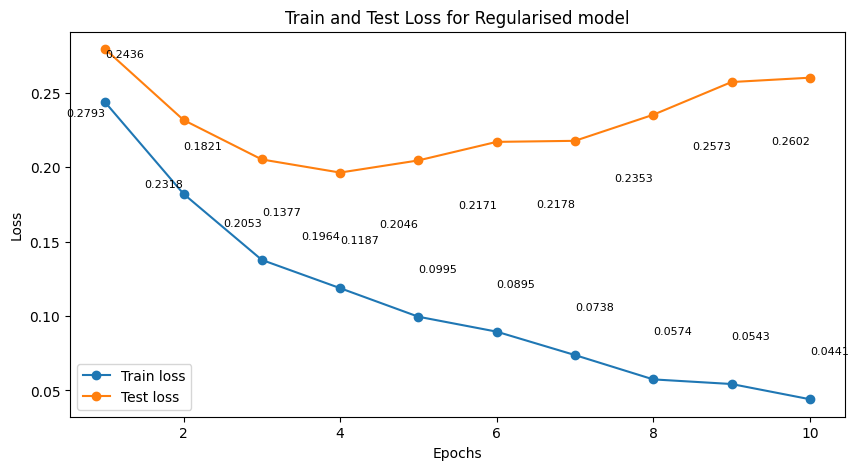

In [16]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling custom utility function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))


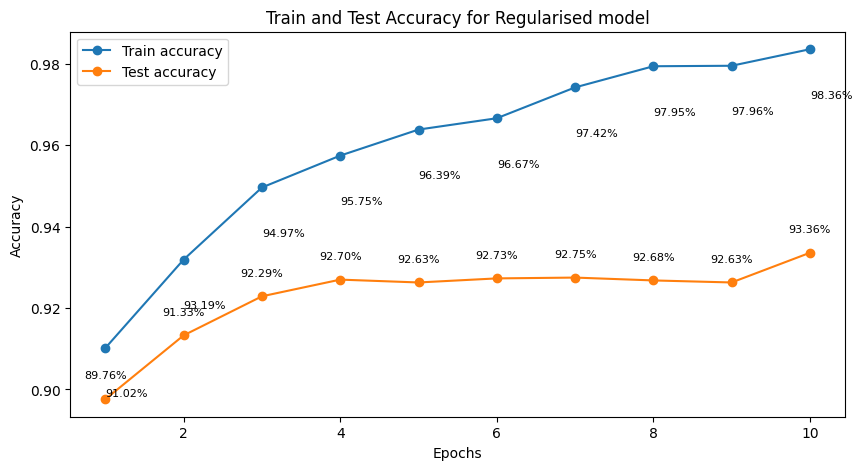

In [17]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling custom utility function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))


In [18]:
# Apply only weight decay technique
train_loader, test_loader = load_fashionMNIST_data(batch_size=64, augmentation=False)

# Initialize model
model = NetFashion().to(device)

epochs = 10  # Increasing the number of epochs by 5 since the learning will be more gradual.

# Define optimizer with weight decay
optimiser = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

# Train model
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:

loss: 2.303181  [   64/60000]
loss: 0.556824  [ 6464/60000]
loss: 0.359227  [12864/60000]
loss: 0.368574  [19264/60000]
loss: 0.490784  [25664/60000]
loss: 0.489531  [32064/60000]
loss: 0.415493  [38464/60000]
loss: 0.377484  [44864/60000]
loss: 0.460008  [51264/60000]
loss: 0.440063  [57664/60000]


Epochs:  10%|█         | 1/10 [00:32<04:54, 32.71s/it]

Train Error: 
 Accuracy: 86.6%, Avg loss: 0.383251 

Test Error: 
 Accuracy: 85.6%, Avg loss: 0.402506 

Epoch 2:

loss: 0.366295  [   64/60000]
loss: 0.374352  [ 6464/60000]
loss: 0.342926  [12864/60000]
loss: 0.396358  [19264/60000]
loss: 0.265535  [25664/60000]
loss: 0.651405  [32064/60000]
loss: 0.267787  [38464/60000]
loss: 0.373707  [44864/60000]
loss: 0.441876  [51264/60000]
loss: 0.316137  [57664/60000]


Epochs:  20%|██        | 2/10 [01:05<04:21, 32.74s/it]

Train Error: 
 Accuracy: 87.2%, Avg loss: 0.351168 

Test Error: 
 Accuracy: 86.0%, Avg loss: 0.376439 

Epoch 3:

loss: 0.319966  [   64/60000]
loss: 0.193448  [ 6464/60000]
loss: 0.369361  [12864/60000]
loss: 0.323645  [19264/60000]
loss: 0.295699  [25664/60000]
loss: 0.495322  [32064/60000]
loss: 0.297736  [38464/60000]
loss: 0.507627  [44864/60000]
loss: 0.444539  [51264/60000]
loss: 0.337796  [57664/60000]


Epochs:  30%|███       | 3/10 [01:38<03:49, 32.83s/it]

Train Error: 
 Accuracy: 88.4%, Avg loss: 0.328246 

Test Error: 
 Accuracy: 87.4%, Avg loss: 0.352730 

Epoch 4:

loss: 0.201295  [   64/60000]
loss: 0.338927  [ 6464/60000]
loss: 0.373744  [12864/60000]
loss: 0.318000  [19264/60000]
loss: 0.327998  [25664/60000]
loss: 0.467289  [32064/60000]
loss: 0.254313  [38464/60000]
loss: 0.242074  [44864/60000]
loss: 0.156909  [51264/60000]
loss: 0.295212  [57664/60000]


Epochs:  40%|████      | 4/10 [02:11<03:17, 32.89s/it]

Train Error: 
 Accuracy: 87.8%, Avg loss: 0.336939 

Test Error: 
 Accuracy: 86.9%, Avg loss: 0.361909 

Epoch 5:

loss: 0.331820  [   64/60000]
loss: 0.279439  [ 6464/60000]
loss: 0.340754  [12864/60000]
loss: 0.422647  [19264/60000]
loss: 0.279721  [25664/60000]
loss: 0.318291  [32064/60000]
loss: 0.273874  [38464/60000]
loss: 0.295192  [44864/60000]
loss: 0.171583  [51264/60000]
loss: 0.325987  [57664/60000]


Epochs:  50%|█████     | 5/10 [02:43<02:42, 32.58s/it]

Train Error: 
 Accuracy: 87.9%, Avg loss: 0.322651 

Test Error: 
 Accuracy: 87.2%, Avg loss: 0.348578 

Epoch 6:

loss: 0.175280  [   64/60000]
loss: 0.163665  [ 6464/60000]
loss: 0.404986  [12864/60000]
loss: 0.312641  [19264/60000]
loss: 0.268019  [25664/60000]
loss: 0.349087  [32064/60000]
loss: 0.388119  [38464/60000]
loss: 0.286328  [44864/60000]
loss: 0.288868  [51264/60000]
loss: 0.243474  [57664/60000]


Epochs:  60%|██████    | 6/10 [03:15<02:10, 32.52s/it]

Train Error: 
 Accuracy: 89.2%, Avg loss: 0.306074 

Test Error: 
 Accuracy: 87.8%, Avg loss: 0.332647 

Epoch 7:

loss: 0.386555  [   64/60000]
loss: 0.244309  [ 6464/60000]
loss: 0.366696  [12864/60000]
loss: 0.248003  [19264/60000]
loss: 0.370521  [25664/60000]
loss: 0.279314  [32064/60000]
loss: 0.214710  [38464/60000]
loss: 0.257113  [44864/60000]
loss: 0.396989  [51264/60000]
loss: 0.329089  [57664/60000]


Epochs:  70%|███████   | 7/10 [03:48<01:37, 32.53s/it]

Train Error: 
 Accuracy: 89.0%, Avg loss: 0.305236 

Test Error: 
 Accuracy: 88.1%, Avg loss: 0.334316 

Epoch 8:

loss: 0.329840  [   64/60000]
loss: 0.257216  [ 6464/60000]
loss: 0.282119  [12864/60000]
loss: 0.271141  [19264/60000]
loss: 0.173173  [25664/60000]
loss: 0.304018  [32064/60000]
loss: 0.439125  [38464/60000]
loss: 0.298370  [44864/60000]
loss: 0.310010  [51264/60000]
loss: 0.282314  [57664/60000]


Epochs:  80%|████████  | 8/10 [04:20<01:04, 32.34s/it]

Train Error: 
 Accuracy: 88.6%, Avg loss: 0.311621 

Test Error: 
 Accuracy: 87.3%, Avg loss: 0.339699 

Epoch 9:

loss: 0.243268  [   64/60000]
loss: 0.394292  [ 6464/60000]
loss: 0.307823  [12864/60000]
loss: 0.214953  [19264/60000]
loss: 0.271624  [25664/60000]
loss: 0.198466  [32064/60000]
loss: 0.289878  [38464/60000]
loss: 0.361178  [44864/60000]
loss: 0.332621  [51264/60000]
loss: 0.347146  [57664/60000]


Epochs:  90%|█████████ | 9/10 [04:53<00:32, 32.46s/it]

Train Error: 
 Accuracy: 88.7%, Avg loss: 0.313511 

Test Error: 
 Accuracy: 87.9%, Avg loss: 0.336234 

Epoch 10:

loss: 0.216284  [   64/60000]
loss: 0.195778  [ 6464/60000]
loss: 0.381934  [12864/60000]
loss: 0.495716  [19264/60000]
loss: 0.289372  [25664/60000]
loss: 0.281692  [32064/60000]
loss: 0.371320  [38464/60000]
loss: 0.410803  [44864/60000]
loss: 0.341335  [51264/60000]
loss: 0.425756  [57664/60000]


Epochs: 100%|██████████| 10/10 [05:25<00:00, 32.56s/it]

Train Error: 
 Accuracy: 88.0%, Avg loss: 0.334556 

Test Error: 
 Accuracy: 86.9%, Avg loss: 0.362663 

Done training!


Plotting metrics

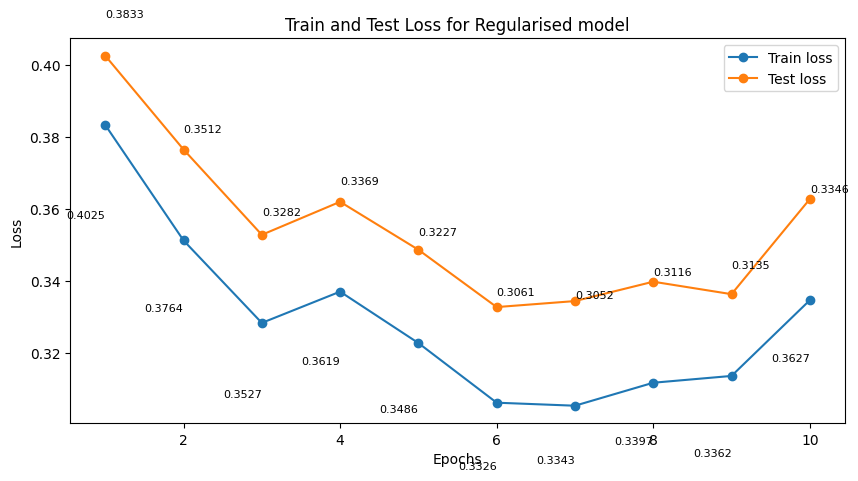

In [19]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling custom utility function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))


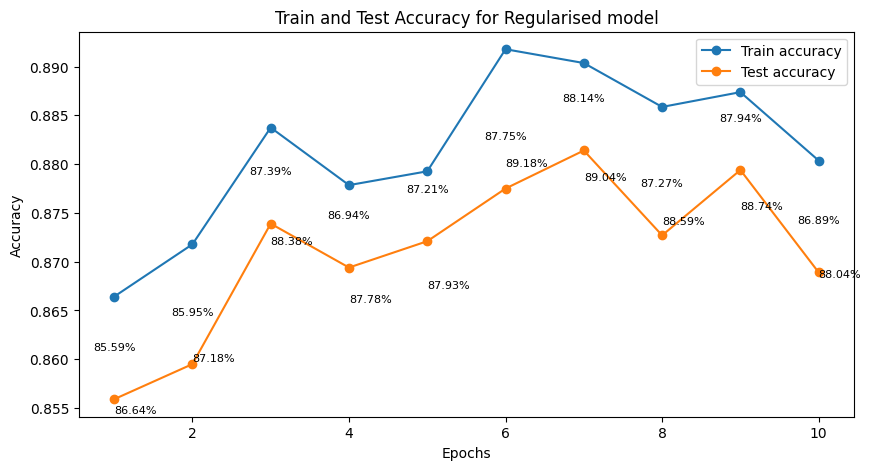

In [20]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling custom utility function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))


Apply all the regularisation techniques together below

In [21]:
# Apply all regularisation techniques
train_loader, test_loader = load_fashionMNIST_data(batch_size=64, augmentation=True)

# Initialize model with regularization
model = NetFashion(useRegularization=True).to(device)

epochs = 10  # Increasing the number of epochs by 5 since the learning will be more gradual.

# Define optimizer with weight decay
optimiser = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

# Train model
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:

loss: 2.302551  [   64/60000]
loss: 0.777907  [ 6464/60000]
loss: 0.545620  [12864/60000]
loss: 0.551568  [19264/60000]
loss: 0.620876  [25664/60000]
loss: 0.551618  [32064/60000]
loss: 0.609499  [38464/60000]
loss: 0.422013  [44864/60000]
loss: 0.520482  [51264/60000]
loss: 0.633187  [57664/60000]


Epochs:  10%|█         | 1/10 [00:47<07:09, 47.69s/it]

Train Error: 
 Accuracy: 83.5%, Avg loss: 0.454978 

Test Error: 
 Accuracy: 82.9%, Avg loss: 0.454465 

Epoch 2:

loss: 0.374457  [   64/60000]
loss: 0.444995  [ 6464/60000]
loss: 0.410272  [12864/60000]
loss: 0.353168  [19264/60000]
loss: 0.401383  [25664/60000]
loss: 0.372803  [32064/60000]
loss: 0.530988  [38464/60000]
loss: 0.360741  [44864/60000]
loss: 0.434002  [51264/60000]
loss: 0.371573  [57664/60000]


Epochs:  20%|██        | 2/10 [01:35<06:20, 47.55s/it]

Train Error: 
 Accuracy: 84.1%, Avg loss: 0.431960 

Test Error: 
 Accuracy: 83.5%, Avg loss: 0.437951 

Epoch 3:

loss: 0.481951  [   64/60000]
loss: 0.348464  [ 6464/60000]
loss: 0.474856  [12864/60000]
loss: 0.521352  [19264/60000]
loss: 0.498644  [25664/60000]
loss: 0.486913  [32064/60000]
loss: 0.363696  [38464/60000]
loss: 0.422952  [44864/60000]
loss: 0.434608  [51264/60000]
loss: 0.477333  [57664/60000]


Epochs:  30%|███       | 3/10 [02:22<05:31, 47.41s/it]

Train Error: 
 Accuracy: 83.9%, Avg loss: 0.427696 

Test Error: 
 Accuracy: 83.8%, Avg loss: 0.425757 

Epoch 4:

loss: 0.375346  [   64/60000]
loss: 0.395684  [ 6464/60000]
loss: 0.544707  [12864/60000]
loss: 0.416828  [19264/60000]
loss: 0.571692  [25664/60000]
loss: 0.554179  [32064/60000]
loss: 0.370444  [38464/60000]
loss: 0.504998  [44864/60000]
loss: 0.514121  [51264/60000]
loss: 0.549508  [57664/60000]


Epochs:  40%|████      | 4/10 [03:09<04:44, 47.38s/it]

Train Error: 
 Accuracy: 84.6%, Avg loss: 0.412901 

Test Error: 
 Accuracy: 84.4%, Avg loss: 0.408216 

Epoch 5:

loss: 0.527694  [   64/60000]
loss: 0.447991  [ 6464/60000]
loss: 0.468166  [12864/60000]
loss: 0.413416  [19264/60000]
loss: 0.504399  [25664/60000]
loss: 0.371038  [32064/60000]
loss: 0.411183  [38464/60000]
loss: 0.492615  [44864/60000]
loss: 0.501995  [51264/60000]
loss: 0.483885  [57664/60000]


Epochs:  50%|█████     | 5/10 [03:57<03:57, 47.51s/it]

Train Error: 
 Accuracy: 84.0%, Avg loss: 0.421117 

Test Error: 
 Accuracy: 84.4%, Avg loss: 0.416304 

Epoch 6:

loss: 0.345559  [   64/60000]
loss: 0.426554  [ 6464/60000]
loss: 0.335299  [12864/60000]
loss: 0.422622  [19264/60000]
loss: 0.338186  [25664/60000]
loss: 0.564099  [32064/60000]
loss: 0.454419  [38464/60000]
loss: 0.476051  [44864/60000]
loss: 0.327507  [51264/60000]
loss: 0.434358  [57664/60000]


Epochs:  60%|██████    | 6/10 [04:44<03:09, 47.35s/it]

Train Error: 
 Accuracy: 85.3%, Avg loss: 0.394638 

Test Error: 
 Accuracy: 84.4%, Avg loss: 0.403062 

Epoch 7:

loss: 0.244591  [   64/60000]
loss: 0.410688  [ 6464/60000]
loss: 0.499635  [12864/60000]
loss: 0.680423  [19264/60000]
loss: 0.462419  [25664/60000]
loss: 0.472938  [32064/60000]
loss: 0.407426  [38464/60000]
loss: 0.377888  [44864/60000]
loss: 0.391608  [51264/60000]
loss: 0.419735  [57664/60000]


Epochs:  70%|███████   | 7/10 [05:31<02:21, 47.19s/it]

Train Error: 
 Accuracy: 86.3%, Avg loss: 0.382213 

Test Error: 
 Accuracy: 85.2%, Avg loss: 0.392788 

Epoch 8:

loss: 0.353401  [   64/60000]
loss: 0.584020  [ 6464/60000]
loss: 0.406287  [12864/60000]
loss: 0.523085  [19264/60000]
loss: 0.476081  [25664/60000]
loss: 0.485106  [32064/60000]
loss: 0.410115  [38464/60000]
loss: 0.360555  [44864/60000]
loss: 0.450133  [51264/60000]
loss: 0.447982  [57664/60000]


Epochs:  80%|████████  | 8/10 [06:18<01:34, 47.30s/it]

Train Error: 
 Accuracy: 85.4%, Avg loss: 0.400625 

Test Error: 
 Accuracy: 85.2%, Avg loss: 0.398930 

Epoch 9:

loss: 0.304181  [   64/60000]
loss: 0.353790  [ 6464/60000]
loss: 0.657187  [12864/60000]
loss: 0.267781  [19264/60000]
loss: 0.461120  [25664/60000]
loss: 0.315795  [32064/60000]
loss: 0.268533  [38464/60000]
loss: 0.437452  [44864/60000]
loss: 0.346764  [51264/60000]
loss: 0.503447  [57664/60000]


Epochs:  90%|█████████ | 9/10 [07:06<00:47, 47.35s/it]

Train Error: 
 Accuracy: 85.1%, Avg loss: 0.393546 

Test Error: 
 Accuracy: 84.7%, Avg loss: 0.400486 

Epoch 10:

loss: 0.270622  [   64/60000]
loss: 0.390099  [ 6464/60000]
loss: 0.306512  [12864/60000]
loss: 0.338999  [19264/60000]
loss: 0.426792  [25664/60000]
loss: 0.360589  [32064/60000]
loss: 0.283742  [38464/60000]
loss: 0.362563  [44864/60000]
loss: 0.210457  [51264/60000]
loss: 0.468372  [57664/60000]


Epochs: 100%|██████████| 10/10 [07:53<00:00, 47.35s/it]

Train Error: 
 Accuracy: 85.5%, Avg loss: 0.384967 

Test Error: 
 Accuracy: 84.8%, Avg loss: 0.397870 

Done training!


Plotting metrics

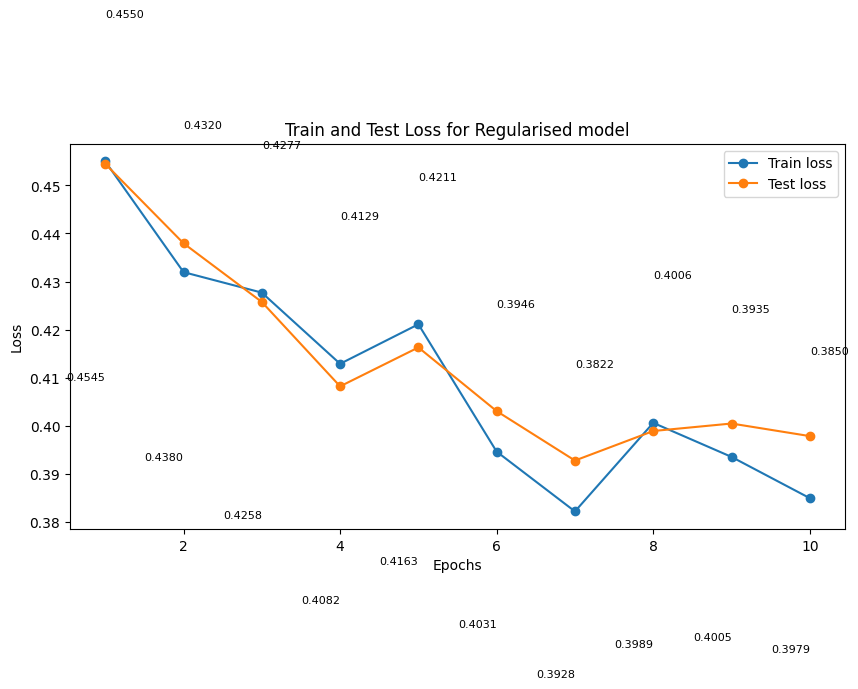

In [22]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling custom utility function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))


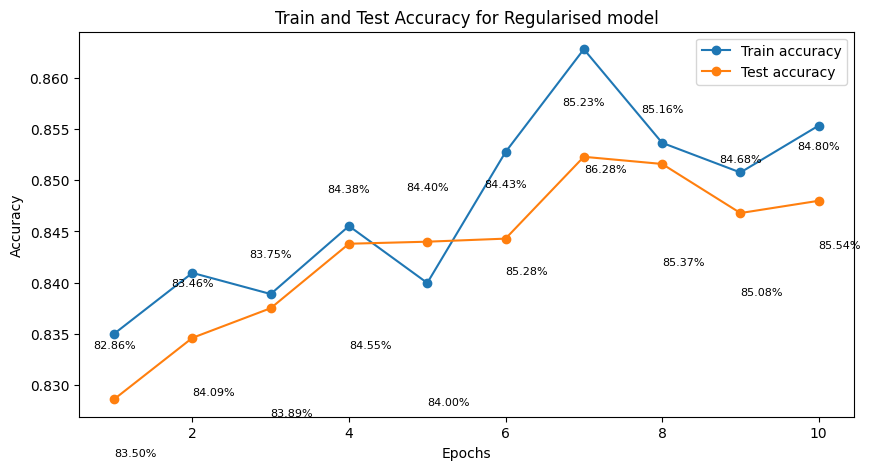

In [23]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling custom utility function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))


## Reflection (1 point)

- **Overfitting:** High training accuracy but lower test accuracy.  
- **Data Augmentation:** Improved generalization with diverse training samples.  
- **Dropout:** Reduced reliance on specific neurons, stabilizing accuracy.  
- **Weight Decay:** Prevented large weights, leading to smoother learning.  
- **Best Approach:** Combining all techniques minimized overfitting.  
- **Conclusion:** Regularization improved test performance without sacrificing too much accuracy.
